In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn import preprocessing
LE = preprocessing.LabelEncoder()

### **Step 1 : 建模**
##### M1 = 9447 ~ 9477 / M2 = 9477 ~ 9507 / M3 = 9507 ~ 9537 / M4 = 9537 ~ 9567

In [4]:
tb_data = './data/'

#### **1. 匯入所有商品30~60(m3)有無購買資料, 基本屬性資料, 網址資料**

In [5]:
fx_m3 = pd.read_csv('./data/fx_m3.csv')
cc_m3 = pd.read_csv('./data/cc_m3.csv')
ln_m3 = pd.read_csv('./data/ln_m3.csv')
wm_m3 = pd.read_csv('./data/wm_m3.csv')
cif_use = pd.read_csv('./data/cif_use.csv')
web_train = pd.read_csv('./data/web_train.csv')
# cif_use.drop(['CUST_START_DT'], axis = 1, inplace = True)

In [6]:
cif_use.loc[~cif_use['GENDER_CODE'].isnull(), :].shape

(187679, 7)

#### **2. 處理外匯資料**

In [7]:
FX = os.path.join(tb_data, 'TBN_FX_TXN.csv')
tb_fx = pd.read_csv(FX)
tb_fx.rename(columns={'TXN_DT':'FX_DT'}, inplace = True)
# tb_fx.sort_index(inplace = True)

In [8]:
# 計算30天以上,120天以內購買次數(m1~m3, 9447~9537)
fx_90 = tb_fx.loc[tb_fx['FX_DT'] <= 9537,['CUST_NO', 'FX_DT']]
fx_90.reset_index(drop=True, inplace=True)
fx_90['FX_DT'] = 1
fx_90 = fx_90.groupby('CUST_NO').sum().reset_index(level=0)
fx_90.columns = ['CUST_NO','FX_count']

In [9]:
# 計算30天以上, 120天以內購買金額總數
fx_90_amt = tb_fx.loc[tb_fx['FX_DT'] <= 9537,['CUST_NO', 'FX_TXN_AMT']]
fx_90_amt.reset_index(drop=True, inplace=True)
fx_90_amt = fx_90_amt.groupby('CUST_NO').sum().reset_index(level=0)
fx_90_amt.columns = ['CUST_NO','AMT_SUM']
#標記購買金額區間
fx_90_amt['AMT_RANGE'] = pd.qcut(fx_90_amt['AMT_SUM'], 4) 
#併入fx_90
fx_90['AMT_RANGE'] = fx_90_amt['AMT_RANGE'] 

In [11]:
# 篩出0~30天(m4)有無購買(Y)
tb_fx['FX_Y'] = [1 if i >= 9537 else 0 for i in tb_fx['FX_DT']]
fx_y = tb_fx.loc[tb_fx['FX_Y'] == 1,['CUST_NO', 'FX_Y']].drop_duplicates(subset = 'CUST_NO')

In [12]:
# 合併fx所需資料
fx_train = fx_90.merge(fx_y, on = 'CUST_NO', how = 'left')
fx_train['FX_Y'] = fx_train['FX_Y'].fillna(0)
fx_train['AMT_RANGE'] = LE.fit_transform(fx_train['AMT_RANGE'])+1

In [13]:
fx_train.head()

,CUST_NO,FX_count,AMT_RANGE,FX_Y
0,--0PHCW9D_3SAAFS,1,2,1.0
1,--1YNJZSSOXDF6UU,4,4,0.0
2,--3NF5SUEEEAWOPI,3,4,0.0
3,--8BVNAAVAUSW6X8,1,1,0.0
4,--BKCXWIQJK5R8_C,1,1,0.0


#### **3. 以基本屬性為底,合併網址、外匯、其他商品m3有無購買之資料**

In [14]:
fx_forecast = cif_use.merge(web_train, on = 'CUST_NO', how = 'left').merge(fx_train, on = 'CUST_NO', how = 'left').merge(fx_m3, on = 'CUST_NO', how = 'left')\
.merge(cc_m3, on = 'CUST_NO', how = 'left').merge(ln_m3, on = 'CUST_NO', how = 'left').merge(wm_m3, on = 'CUST_NO', how = 'left')

In [15]:
fx_forecast.loc[~fx_forecast['GENDER_CODE'].isnull(),:].shape

(187679, 21)

In [18]:
fx_forecast.isnull().any()

CUST_NO              False
AGE                  False
CHILDREN_CNT         False
EDU_CODE             False
GENDER_CODE          False
INCOME_RANGE_CODE    False
WORK_MTHS            False
web_1                False
web_2                False
web_3                False
web_4                False
web_5                False
web_6                False
web_7                False
FX_count             False
AMT_RANGE            False
FX_Y                 False
FX_30                False
CC_30                False
LN_30                False
WM_30                False
dtype: bool

In [17]:
fx_forecast_fill = [i for i in fx_forecast.columns if i !='CUST_NO' and i !='GENDER_CODE'] 
fx_forecast[fx_forecast_fill] = fx_forecast[fx_forecast_fill].fillna(0)
# fx_forecast['AMT_RANGE'] = fx_forecast['AMT_RANGE'].cat.add_categories('0')
# fx_forecast['AMT_RANGE'].fillna(0, inplace =True)
# fx_forecast['GENDER_CODE'] = fx_forecast['GENDER_CODE'].fillna(2)
fx_forecast_list = [i for i in fx_forecast.columns if i !='CUST_NO'] 
fx_forecast[fx_forecast_list] = fx_forecast[fx_forecast_list].apply(lambda x:x.astype(int))

#### **4. 決策樹**

In [19]:
X = fx_forecast.drop(['CUST_NO', 'FX_Y'], axis = 1)
Y = fx_forecast['FX_Y']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30,random_state=0)

In [20]:
Y.value_counts()

0    176957
1     10722
Name: FX_Y, dtype: int64

In [21]:
Y_train.dtypes

dtype('int32')

In [22]:
print('X_train :',X_train.shape)
print('Y_train', Y_train.shape)
print('X_test :', X_test.shape)
print('Y_test', Y_test.shape)

X_train : (131375, 19)
Y_train (131375,)
X_test : (56304, 19)
Y_test (56304,)


In [23]:
fx_tree = DecisionTreeClassifier(criterion = "entropy",
                               max_depth=3, min_samples_leaf=5)
fx_tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [24]:
fx_predict = fx_tree.predict(X_test)

In [25]:
# print(classification_report(Y_test,fx_predict))
print("Accuracy is ", accuracy_score(Y_test, fx_predict)*100)
# print(confusion_matrix(y_test,predictions))

Accuracy is  95.00035521454959


##### **ROC**

In [26]:
from sklearn.metrics import roc_curve, auc

<Figure size 432x288 with 0 Axes>

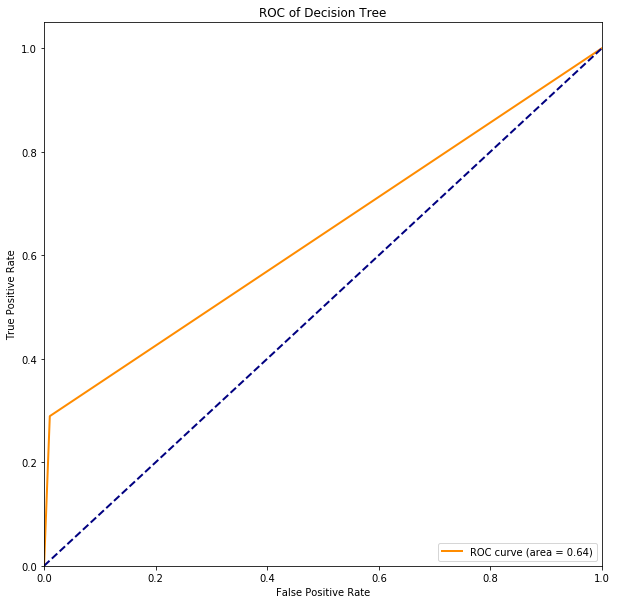

In [27]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(Y_test, fx_predict) ###計算True Postive 和 False Positive False Postive為橫軸，True Postive為縱軸
roc_auc = auc(fpr,tpr) ###計算AUC
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###False Postive為橫軸，True Postive為縱軸
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Decision Tree')
plt.legend(loc="lower right")
plt.show()

#### **5. 隨機森林**

In [28]:
from sklearn import cross_validation, ensemble, preprocessing, metrics

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [29]:
fx_forest = ensemble.RandomForestClassifier(n_estimators = 100)
fx_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
fx_f_predict = fx_forest.predict(X_test)

In [31]:
print("Accuracy is ", accuracy_score(Y_test, fx_f_predict)*100)

Accuracy is  94.45865302642797


<Figure size 432x288 with 0 Axes>

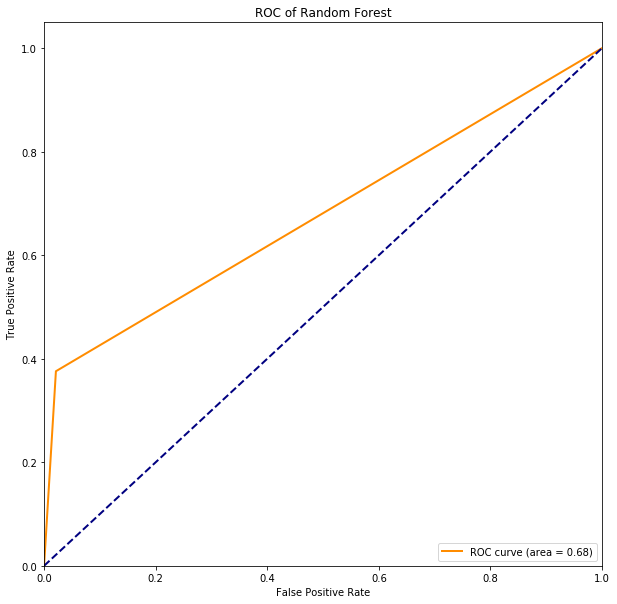

In [32]:
fpr,tpr,threshold = roc_curve(Y_test, fx_f_predict) ###計算True Postive 和 False Positive 
roc_auc = auc(fpr,tpr) ###計算AUC
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###False Postive為橫軸，True Postive為縱軸
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest')
plt.legend(loc="lower right")
plt.show()

#### **6. XGBoost**

In [33]:
from xgboost import XGBClassifier

In [34]:
xgb = XGBClassifier()

In [35]:
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [36]:
fx_xgb_predict = xgb.predict(X_test)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [37]:
print("Accuracy is ", accuracy_score(Y_test, fx_xgb_predict)*100)

Accuracy is  94.9914748508099


<Figure size 432x288 with 0 Axes>

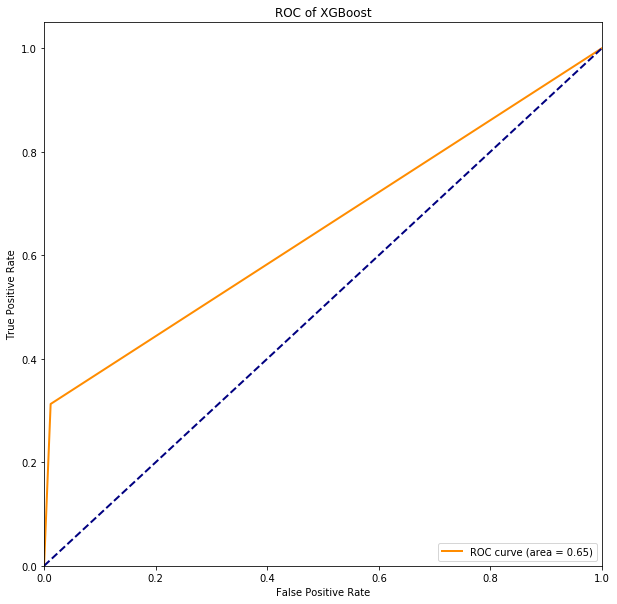

In [38]:
fpr,tpr,threshold = roc_curve(Y_test, fx_xgb_predict) ###計算True Postive 和 False Positive
roc_auc = auc(fpr,tpr) ###計算AUC

plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###False Postive為橫軸，True Postive為縱軸
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of XGBoost')
plt.legend(loc="lower right")
plt.show()

### **Step 2 : Load 預測資料集**

In [39]:
Y_zero  = pd.read_csv('./data/TBN_Y_ZERO.csv')
# Y_zero  = pd.read_csv('./data/TBN_Y_ZERO.csv', usecols = ['CUST_NO', 'FX_IND'])

#### **1. 匯入所有商品0~30(m4)有無購買,網址資料(m3,m4)**

In [40]:
fx_m4 = pd.read_csv('./data/fx_m4.csv')
cc_m4 = pd.read_csv('./data/cc_m4.csv')
ln_m4 = pd.read_csv('./data/ln_m4.csv')
wm_m4 = pd.read_csv('./data/wm_m4.csv')
web_test = pd.read_csv('./data/web_test.csv')

In [41]:
web_test.shape

(106655, 8)

#### **2. 處理外匯資料**

In [44]:
# 計算0~90天以內購買次數(m2~m4, 9477~9567)
fx_24 = tb_fx.loc[tb_fx['FX_DT'] > 9477,['CUST_NO', 'FX_DT']]
fx_24.reset_index(drop=True, inplace=True)
fx_24['FX_DT'] = 1
fx_24 = fx_24.groupby('CUST_NO').sum().reset_index(level=0)
fx_24.columns = ['CUST_NO','FX_count']

In [45]:
# 計算0~90天以內購買金額總數
fx_24_amt = tb_fx.loc[tb_fx['FX_DT'] > 9477,['CUST_NO', 'FX_TXN_AMT']]
fx_24_amt.reset_index(drop=True, inplace=True)
fx_24_amt = fx_24_amt.groupby('CUST_NO').sum().reset_index(level=0)
fx_24_amt.columns = ['CUST_NO','AMT_SUM']
#標記購買金額區間
fx_24_amt['AMT_RANGE'] = pd.qcut(fx_24_amt['AMT_SUM'], 4)
fx_24_amt['AMT_RANGE'] = LE.fit_transform(fx_24_amt['AMT_RANGE'])+1
#併入fx_24
fx_24['AMT_RANGE'] = fx_24_amt['AMT_RANGE']

In [47]:
# 合併fx所需資料
fx_test = fx_24
fx_test.isnull().any()

CUST_NO      False
FX_count     False
AMT_RANGE    False
dtype: bool

#### **3. 以Y為底，合併基本屬性,網址、外匯、其他商品m3有無購買之資料**

In [48]:
Y_fx = Y_zero[['CUST_NO']].merge(cif_use, on = 'CUST_NO', how = 'left').merge(web_test, on = 'CUST_NO', how = 'left').merge(fx_test, on = 'CUST_NO', how = 'left')\
.merge(fx_m4, on = 'CUST_NO', how = 'left').merge(cc_m4, on = 'CUST_NO', how = 'left').merge(ln_m4, on = 'CUST_NO', how = 'left').merge(wm_m4, on = 'CUST_NO', how = 'left')

In [49]:
Y_fx.loc[~Y_fx['AGE'].isnull(),:].shape

(29854, 20)

In [54]:
Y_fx.isnull().any()
# Y_fx.info()

CUST_NO              False
AGE                  False
CHILDREN_CNT         False
EDU_CODE             False
GENDER_CODE          False
INCOME_RANGE_CODE    False
WORK_MTHS            False
web_1                False
web_2                False
web_3                False
web_4                False
web_5                False
web_6                False
web_7                False
FX_count             False
AMT_RANGE            False
FX_30                False
CC_30                False
LN_30                False
WM_30                False
dtype: bool

##### **3.1 處理基本屬性資料**

In [51]:
m_edu = round(Y_fx.loc[:,'EDU_CODE'].mean())
m_income = round(Y_fx.loc[:, 'INCOME_RANGE_CODE'].mean())
m_work = round(Y_fx.loc[:, 'WORK_MTHS'].mean())
m_age = round(Y_fx.loc[:, 'AGE'].mean())
name_ = Y_fx.columns.tolist()[1:7]
mean_ = [m_age, 0, m_edu, 2, m_income, m_work] 
for i,j in zip(name_, mean_):
    Y_fx.loc[:,i] = Y_fx.loc[:, i].fillna(j)

##### 3.2 **處理剩餘na**

In [57]:
# fx_forecast['AMT_RANGE'] = fx_forecast['AMT_RANGE'].cat.add_categories('0')
# fx_forecast['AMT_RANGE'].fillna('0', inplace =True)
# # fx_forecast['GENDER_CODE'] = fx_forecast['GENDER_CODE'].fillna(2)
# fx_forecast_list = [i for i in fx_forecast.columns if i !='CUST_NO' and i != 'AMT_RANGE'] 
# fx_forecast[fx_forecast_list] = fx_forecast[fx_forecast_list].apply(lambda x:x.astype(int))

In [58]:
# Y_fx['AMT_RANGE'] = Y_fx['AMT_RANGE'].cat.add_categories('0')
# Y_fx['AMT_RANGE'].fillna('0', inplace = True)

In [53]:
# Y_fx = Y_fx.fillna(0)
Y_fx_list = [i for i in Y_fx.columns if i !='CUST_NO']
Y_fx[Y_fx_list] = Y_fx[Y_fx_list].fillna(0)
Y_fx[Y_fx_list] = Y_fx[Y_fx_list].apply(lambda x:x.astype(int))

#### **4. 決策樹**

In [55]:
X_train = fx_forecast.drop(['CUST_NO', 'FX_Y'], axis = 1)
Y_train = fx_forecast['FX_Y']
X_test = Y_fx.drop(['CUST_NO'], axis = 1)

In [62]:
print('X_train :',X_train.shape)
print('Y_train', Y_train.shape)
print('X_test :', X_test.shape)
# print('Y_test', Y_test.shape)

X_train : (187679, 19)
Y_train (187679,)
X_test : (30000, 19)


In [63]:
fx_tree = DecisionTreeClassifier(criterion = "entropy",
                               max_depth=3, min_samples_leaf=5)
fx_tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [64]:
fx_predict = fx_tree.predict(X_test).tolist()

In [81]:
fx_predict.count(1)

313

In [65]:
Y_zero['FX_IND'] = fx_predict

In [95]:
# Y_zero[Y_zero['FX_IND'] == 1]

In [66]:
TBN_Y_FX = Y_zero.loc[:,['CUST_NO', 'FX_IND']]
TBN_Y_FX.head()
TBN_Y_FX.to_csv('./data/TBN_Y_FX_30.csv', index = False)

##### **Random Forest**

In [67]:
fx_forest = ensemble.RandomForestClassifier(n_estimators = 100)
fx_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [68]:
fx_f_predict = fx_forest.predict(X_test)

In [80]:
fx_f_predict.tolist().count(1)

845

In [69]:
Y_zero['FX_IND'] = fx_f_predict

In [70]:
TBN_Y_FX = Y_zero.loc[:,['CUST_NO', 'FX_IND']]
TBN_Y_FX.head()
TBN_Y_FX.to_csv('./data/TBN_Y_FX_Forest_30.csv', index = False)

##### **XGBoost**

In [71]:
xgb = XGBClassifier()

In [72]:
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [73]:
fx_xgb_predict = xgb.predict(X_test)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [75]:
Y_zero['FX_IND'] = fx_xgb_predict

In [79]:
fx_xgb_predict.tolist().count(1)

476

In [76]:
TBN_Y_FX = Y_zero.loc[:,['CUST_NO', 'FX_IND']]
TBN_Y_FX.head()
TBN_Y_FX.to_csv('./data/TBN_Y_FX_XGB_30.csv', index = False)